In [1]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
# r_cols = ['place_id', 'userid', 'travel_date', 'point']
# ratings = pd.read_csv('C:/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = pd.read_csv('./travel_records.csv')
ratings = ratings[['place_id', 'userid', 'point']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

K = 200
mu = ratings_train.point.mean()
M = ratings.userid.max() + 1
N = ratings.place_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

R = layers.dot([P_embedding, Q_embedding], axes=2)
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

model = Model(inputs=[user,item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 200)       2322400     ['input_7[0][0]']                
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 200)       42400       ['input_8[0][0]']                
                                                                                            

In [21]:
result = model.fit(
    x=[ratings_train.userid.values, ratings_train.place_id.values],
    y=ratings_train.point.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [ratings_test.userid.values, ratings_test.place_id.values],
        ratings_test.point.values - mu
    )
)

Epoch 1/60
 6/68 [=>............................] - ETA: 0s - loss: 20.6026 - RMSE: 0.8126 

2022-11-15 22:52:09.846236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 1s 13ms/step - loss: 20.3431 - RMSE: 0.7979 - val_loss: 20.0768 - val_RMSE: 0.8008
Epoch 2/60
 1/68 [..............................] - ETA: 0s - loss: 20.0142 - RMSE: 0.7360

2022-11-15 22:52:10.666256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 1s 10ms/step - loss: 19.8172 - RMSE: 0.7917 - val_loss: 19.5585 - val_RMSE: 0.7999
Epoch 3/60
68/68 [==============================] - 1s 10ms/step - loss: 19.3061 - RMSE: 0.7844 - val_loss: 19.0542 - val_RMSE: 0.7991
Epoch 4/60
68/68 [==============================] - 1s 10ms/step - loss: 18.8083 - RMSE: 0.7850 - val_loss: 18.5635 - val_RMSE: 0.7983
Epoch 5/60
68/68 [==============================] - 1s 10ms/step - loss: 18.3237 - RMSE: 0.7910 - val_loss: 18.0861 - val_RMSE: 0.7978
Epoch 6/60
68/68 [==============================] - 1s 10ms/step - loss: 17.8525 - RMSE: 0.7893 - val_loss: 17.6215 - val_RMSE: 0.7972
Epoch 7/60
68/68 [==============================] - 1s 10ms/step - loss: 17.3941 - RMSE: 0.7842 - val_loss: 17.1694 - val_RMSE: 0.7966
Epoch 8/60
68/68 [==============================] - 1s 10ms/step - loss: 16.9474 - RMSE: 0.7882 - val_loss: 16.7295 - val_RMSE: 0.7960
Epoch 9/60
68/68 [==============================] - 1s 10ms/step -

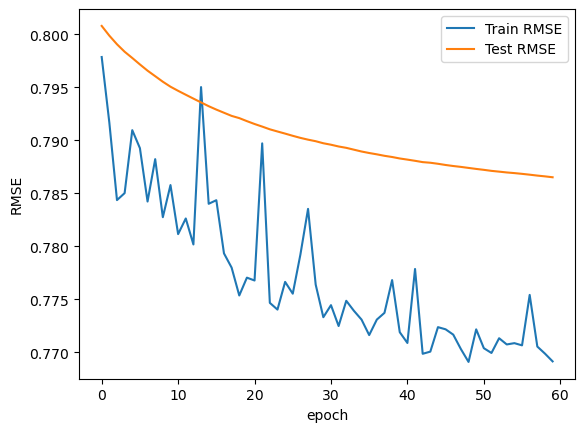

In [22]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [23]:
user_ids = ratings_test.userid.values[0:6]
place_ids = ratings_test.place_id.values[0:6]
predictions = model.predict([user_ids, place_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
        place_id  userid  point
15690       123    1798      4
15614       123    5615      5
19124       152    6568      4
1269         55   10777      5
17307       125    5315      3
21486       207    3137      5

Predictions: 
 [[4.4109635]
 [4.4162393]
 [4.380667 ]
 [4.449589 ]
 [4.467372 ]
 [4.360977 ]]


2022-11-15 22:52:52.494775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.userid.values
movie_ids = ratings_test.place_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.point)

RMSE2(y_true, y_pred)


0.785815743747196

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

K = 200
mu = ratings_train.point.mean()
M = ratings.userid.max() + 1
N = ratings.place_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Keras model
user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

#Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

#Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user,item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       2322400     ['input_5[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 200)       42400       ['input_6[0][0]']                
                                                                                            

In [17]:
result = model.fit(
    x=[ratings_train.userid.values, ratings_train.place_id.values],
    y=ratings_train.point.values - mu,
    epochs=65,
    batch_size=512,
    validation_data=(
        [ratings_test.userid.values, ratings_test.place_id.values],
        ratings_test.point.values - mu
    )
)

Epoch 1/65


2022-11-15 22:49:59.361495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 20.4720 - RMSE: 0.7911

2022-11-15 22:50:01.226122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 3s 30ms/step - loss: 20.4720 - RMSE: 0.7911 - val_loss: 20.3387 - val_RMSE: 0.8016
Epoch 2/65
34/34 [==============================] - 0s 15ms/step - loss: 20.2052 - RMSE: 0.7891 - val_loss: 20.0741 - val_RMSE: 0.8010
Epoch 3/65
34/34 [==============================] - 1s 15ms/step - loss: 19.9424 - RMSE: 0.7890 - val_loss: 19.8131 - val_RMSE: 0.8004
Epoch 4/65
34/34 [==============================] - 1s 16ms/step - loss: 19.6829 - RMSE: 0.7870 - val_loss: 19.5557 - val_RMSE: 0.7999
Epoch 5/65
34/34 [==============================] - 0s 14ms/step - loss: 19.4271 - RMSE: 0.7881 - val_loss: 19.3017 - val_RMSE: 0.7994
Epoch 6/65
34/34 [==============================] - 1s 15ms/step - loss: 19.1743 - RMSE: 0.7871 - val_loss: 19.0512 - val_RMSE: 0.7989
Epoch 7/65
34/34 [==============================] - 0s 14ms/step - loss: 18.9256 - RMSE: 0.7860 - val_loss: 18.8041 - val_RMSE: 0.7984
Epoch 8/65
34/34 [==============================] - 1s 15ms/step -

34/34 [==============================] - 1s 15ms/step - loss: 9.4712 - RMSE: 0.7662 - val_loss: 9.4238 - val_RMSE: 0.7840
Epoch 62/65
34/34 [==============================] - 0s 15ms/step - loss: 9.3532 - RMSE: 0.7648 - val_loss: 9.3071 - val_RMSE: 0.7840
Epoch 63/65
34/34 [==============================] - 0s 14ms/step - loss: 9.2372 - RMSE: 0.7659 - val_loss: 9.1918 - val_RMSE: 0.7837
Epoch 64/65
34/34 [==============================] - 1s 15ms/step - loss: 9.1227 - RMSE: 0.7651 - val_loss: 9.0781 - val_RMSE: 0.7836
Epoch 65/65
34/34 [==============================] - 0s 14ms/step - loss: 9.0095 - RMSE: 0.7641 - val_loss: 8.9660 - val_RMSE: 0.7835


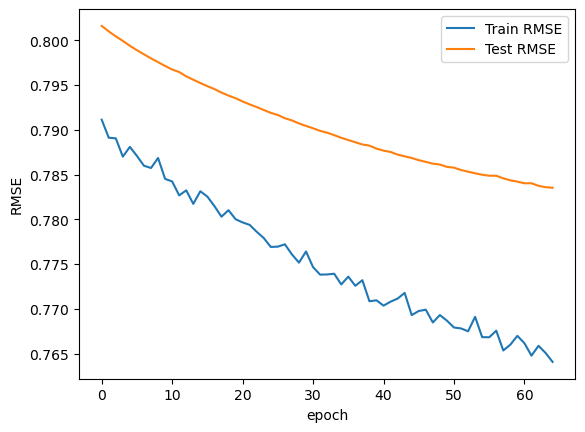

In [18]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [19]:
user_ids = ratings_test.userid.values[0:6]
place_ids = ratings_test.place_id.values[0:6]
predictions = model.predict([user_ids, place_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
        place_id  userid  point
15690       123    1798      4
15614       123    5615      5
19124       152    6568      4
1269         55   10777      5
17307       125    5315      3
21486       207    3137      5

Predictions: 
 [[4.4160347]
 [4.4291506]
 [4.3813696]
 [4.507661 ]
 [4.520993 ]
 [4.3707304]]


2022-11-15 22:51:40.578190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
